# TP1

Importamos las librerias necesarias.

In [2]:
import math
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2, norm, expon
from scipy.stats import kstest
from scipy.stats import distributions
from scipy import  stats
import pandas as pd
import json

## Ejercicio 1

### Implementamos el generador

Implementamos el generador de enteros de 32 bits de periodo 2^128 - 1. \\
Debido a que Python no tiene el problema de desbordamiento de enteros, limitamos la operación para números de 32 bits.

In [3]:
class XORSHIFT128:
    def __init__(self, x, y, z, w):
        self.periodo = 2**128 - 1
        self.x = x
        self.y = y
        self.z = z
        self.w = w

    def rnd(self):
        tmp = (self.x^(self.x<<11)) & 0xFFFFFFFF # Resultado en 32 bits
        self.x=self.y
        self.y=self.z
        self.z=self.w
        self.w = (self.w ^ (self.w >> 19)) ^ (tmp ^ (tmp >> 8)) & 0xFFFFFFFF # Resultado en 32 bits
        return self.w
        
    def rnd_cero_uno(self):
        return self.rnd()/(2**32 - 1)
    
    def muestra_cero_uno(self, n):
        muestra = []
        for _ in range(n):
            muestra.append(self.rnd_cero_uno())
        return muestra

    def muestra_entre(self, minimo, maximo, n):
        muestra = []
        for _ in range(n):
            m = minimo + self.rnd_cero_uno() * (maximo - minimo)
            muestra.append(m)
        return muestra

generador = XORSHIFT128(123456789, 362436069, 521288629, 88675123)
for _ in range(5):
    numero_generado = generador.rnd()
    print(numero_generado, type(numero_generado))

3701687786 <class 'int'>
458299110 <class 'int'>
2500872618 <class 'int'>
3633119408 <class 'int'>
516391518 <class 'int'>


### Normalizamos los numeros generados

Para generar números aleatorios entre 0 y 1 debemos dividir entre el numero maximo. Para resolver este ítem se implementó el método rnd_cero_uno()

In [4]:
generador.muestra_cero_uno(5)

[0.5535012051820525,
 0.6053478875209922,
 0.16699309185310107,
 0.03209956549855405,
 0.09204706016277127]

### Vemos que tan bueno es el generador

Generamos una muestra de 10^5 numeros

In [5]:
observaciones = generador.muestra_cero_uno(10**5)

#### Histograma

Primero vemos que tan bien se distribuye entre el 0 y 1. \\
Al graficarlo con un histograma deberiamos ver que los numeros generados esten distribuidos uniformemente entre el 0 y 1, esto es tener una frecuencia muy parecida en todos los subrangos divididos.

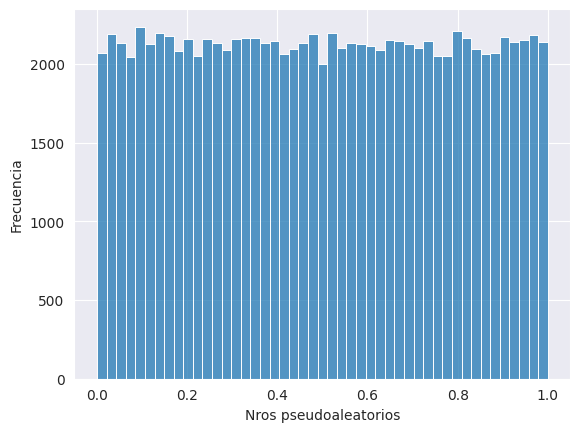

In [6]:
sns_hist=sns.histplot(data=observaciones).set(xlabel="Nros pseudoaleatorios",ylabel="Frecuencia")
plt.show()

Observamos que efectivamente tiene una frecuencia casi constante a lo largo de los subrangos.

#### Boxplot

Al graficar la muestra en un boxplot deberiamos observar lo siguiente:


1. Los valores maximos y minimos debes ser 0 y 1 respectivamente.
1. No deberia haber outliers.
1. Todos los cuartiles deberian coincidir con los valores generados, es decir:
  * Al valor 0.25 se deberia encontrar acumulado el 25% de los datos, i.e. primer cuartil.
  * Al valor 0.5 se deberia encontrar el segundo cuartil (mediana).
  * Al valor 0.75 se deberia encontrar el tercer cuartil.

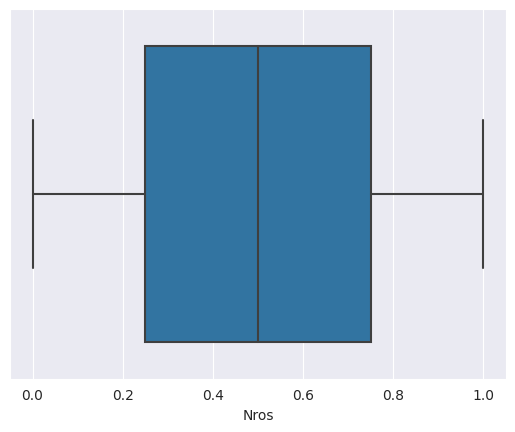

In [7]:
sns_box = sns.boxplot(x=observaciones).set(xlabel="Nros")
plt.show()

Vemos que todo los esperado se cumple.

## Ejercicio 2

Los tests que utilizaremos son:
* Test de frecuencia (Discretización + Chi²)
* Test de Kolmogorov-Smirnov
* Test QQ Plot
* Test espectral

Para cada uno de estos tests, utilizaremos muestras de los siguientes tamaños: 100, 1000 y 100000

In [8]:
muestra1 = generador.muestra_cero_uno(10**2)
muestra2 = generador.muestra_cero_uno(10**3)
muestra3 = generador.muestra_cero_uno(10**5)

### Test de Frecuencia

En primer lugar vamos a discretizar la muestra separando en clases (o grupos). Posteriormente, aplicaremos Chi cuadrado, donde nuestra hipotesis nula será que nuestra muestra presenta una distribución uniforme.

A continuación se encuentran una serie de funciones que serán de utilidad a lo largo del test.

In [9]:
# Devuelve array de frecuencias de un histograma
def obtener_frecuencias(hist):
    frec = []
    for clase in hist.patches:
        frec.append(clase.get_height())
    return frec

# Grafica un histograma
def plot_histograma(muestra, n_bins='sturges'):
    plt.figure()
    hist = sns.histplot(data=muestra, bins=n_bins)

    plt.ylabel("Ocurrencias")
    plt.xlabel("Clases")
    plt.title('Histograma')
    plt.show()
    return hist
    
# Test Chi cuadrado
def test_chi2(frecuencias):
    cant_clases = len(frecuencias)
    pE=1/cant_clases

    cant = sum(frecuencias)
    D2 = sum([(fO - pE*cant)**2 for fO in frecuencias])/(pE*cant)

    niv_significacion = 0.05 
    limite_sup = chi2.ppf(1-niv_significacion, df=cant_clases-1)

    print("Limite superior: {:.2f} ".format(limite_sup))
    print("Estadistico: {:.2f} ".format(D2))

    if D2 <= limite_sup:
        print("Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).")
    else:
        print("Se rechaza la hipótesis nula")

#### Muestra 1 (n = 100)

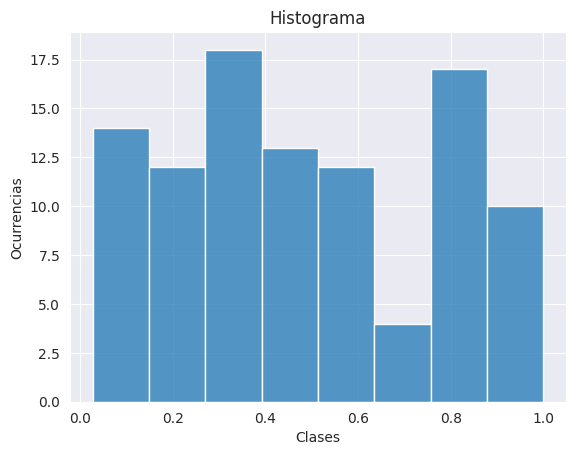

Limite superior: 14.07 
Estadistico: 10.56 
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


In [10]:
# Creamos histograma y obtenemos las frecuencias de cada clase
hist = plot_histograma(muestra1)
frec = obtener_frecuencias(hist)

# Aplicamos test Chi2
test_chi2(frec)

#### Muestra 2 (n = 1000)

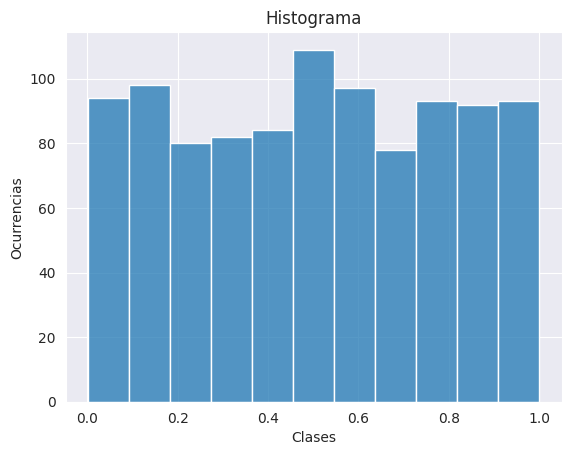

Limite superior: 18.31 
Estadistico: 9.32 
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


In [11]:
# Creamos histograma y obtenemos las frecuencias de cada clase
hist = plot_histograma(muestra2)
frec = obtener_frecuencias(hist)

# Aplicamos test Chi2
test_chi2(frec)

Probamos con un número más grande de bins: 50

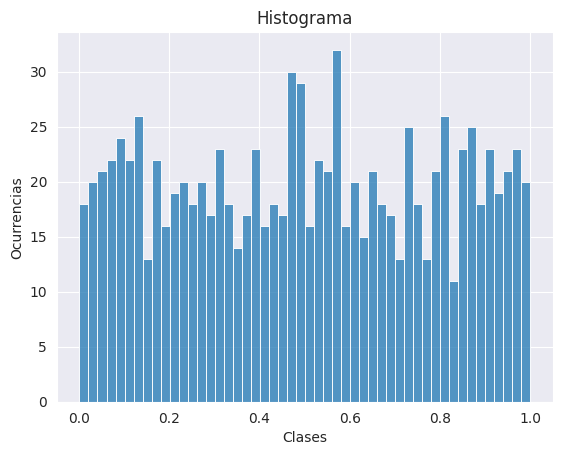

Limite superior: 66.34 
Estadistico: 47.40 
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


In [12]:
# Creamos histograma y obtenemos las frecuencias de cada clase
hist = plot_histograma(muestra2, 50)
frec = obtener_frecuencias(hist)

# Aplicamos test Chi2
test_chi2(frec)

#### Muestra 3 (n = 100000)

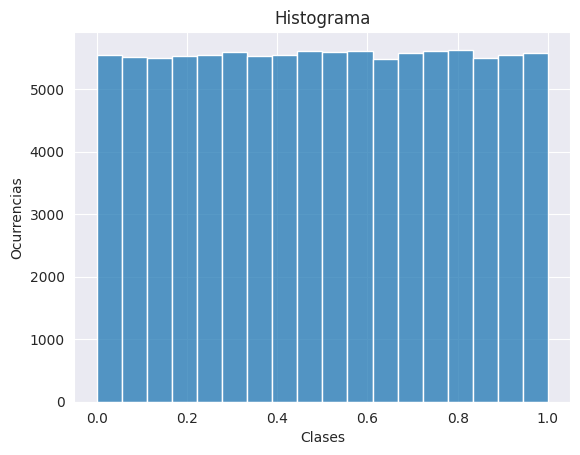

Limite superior: 27.59 
Estadistico: 6.60 
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


In [13]:
# Creamos histograma y obtenemos las frecuencias de cada clase
hist = plot_histograma(muestra3)
frec = obtener_frecuencias(hist)

# Aplicamos test Chi2
test_chi2(frec)

Probamos con un número más grande de bins: 100

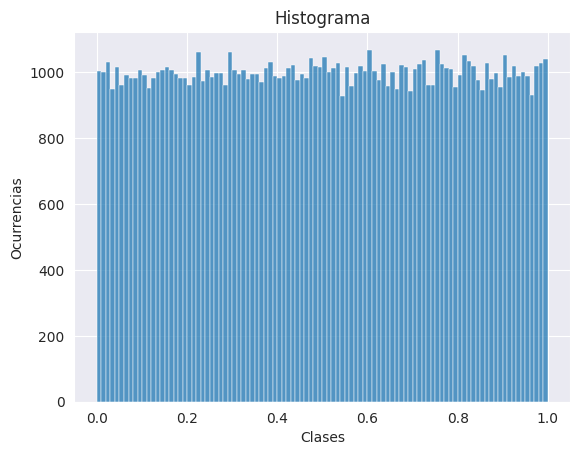

Limite superior: 123.23 
Estadistico: 88.48 
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


In [14]:
# Creamos histograma y obtenemos las frecuencias de cada clase
hist = plot_histograma(muestra3, 100)
frec = obtener_frecuencias(hist)

# Aplicamos test Chi2
test_chi2(frec)

#### Resultados

Una vez realizados los tests, analicemos los resultados. En primer lugar, notamos que son coherentes, ya que a medida que incrementamos el tamaño de la muestra, esta tiende a una distribución uniforme, lo cual concuerda con lo esperado.

Además, podemos ver que para la única muestra que se rechazó la hipotesis nula es la de tamaño 100, mientras que para las muestras de tamaño 1000 y 100000 no habia evidencia suficiente para rechazarla.

### Test Kolmogorov-Smirnov

En primer lugar, vamos a visualizar un gráfico comparando la función de distribución acumulada (CDF) de una uniforme (0,1) con la función de distribución acumulada empírica (ECDF) construida a partir de la muestra obtenida. Posteriormente, aplicaremos el test de Kolmogorov-Smirnov, donde la hipotesis nula será que nuestra muestra presenta una distribución uniforme.

En este caso la hipótesis H0 es: La distribución U(0,1) es "idéntica" a la distribución ECDF.

A continuación se encuentran una serie de funciones que serán de utilidad a lo largo del test.

In [15]:
# Grafica las funciones ECFD y CFD
def plot_ecfd_vs_cfd(muestra):
    plt.figure()
    sns.ecdfplot(data=muestra, label='ECDF')
    uniform_data = np.linspace(0,1,len(muestra))
    plt.plot(np.sort(uniform_data), np.linspace(0, 1, len(uniform_data), endpoint=False), color='r', label='CDF')

    plt.legend(title="Funciones")
    plt.ylabel("F(x)")
    plt.xlabel("x")
    plt.title('ECDF vs CDF')
    plt.show()
    

# Test Kolmogorov-Smirnov
def test_kolmogorov_smirnov(muestra):
    estadistico_ks, pvalor_ks= kstest(muestra, 'uniform')
    print("KS = %f, pValor = %f" % (estadistico_ks, pvalor_ks))

    if pvalor_ks < 0.05:
        print("Se rechaza la hipótesis nula")
    else:
        print("Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).")

#### Muestra 1 (n = 100)

In [16]:
test_kolmogorov_smirnov(muestra1)

KS = 0.077872, pValor = 0.552693
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


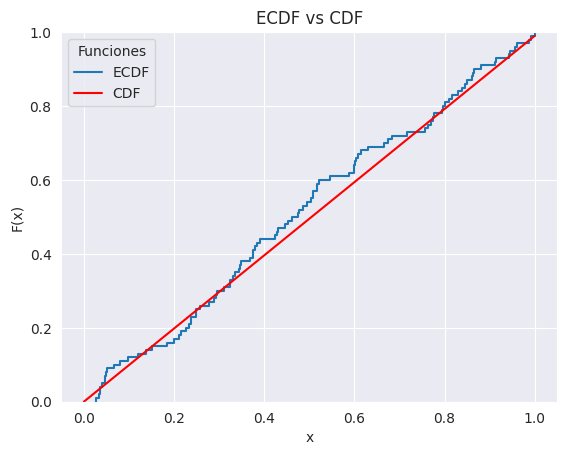

In [17]:
plot_ecfd_vs_cfd(muestra1)

#### Muestra 2 (n = 1000)

In [18]:
test_kolmogorov_smirnov(muestra2)

KS = 0.020311, pValor = 0.795916
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


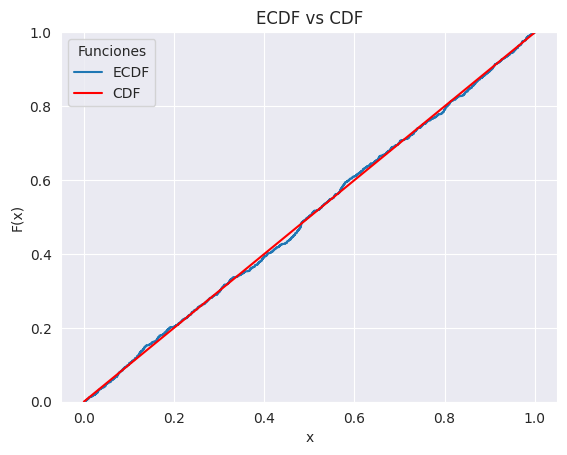

In [19]:
plot_ecfd_vs_cfd(muestra2)

#### Muestra 3 (n = 100000)

In [20]:
test_kolmogorov_smirnov(muestra3)

KS = 0.002205, pValor = 0.715037
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


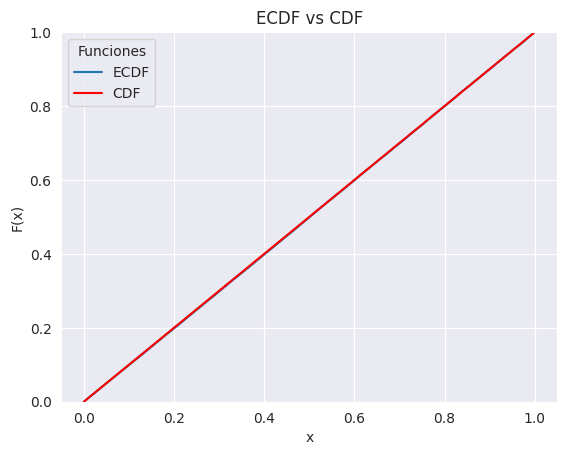

In [21]:
plot_ecfd_vs_cfd(muestra3)

#### Resultados

Similar al test anterior, para la muestra pequeña (n = 100) se rechazó la hipotesis nula debido a que la cantidad de muestras no era suficiente, de hecho el p-valor estuvo cerca de 0,05. Para las dos siguientes muestras (n=1000 y n=100000), no hay evidencia suficiente para considerar que no siguen una distribución uniforme.

A su vez, comparando las funciones de distribución acumulada real vs empírica, vemos claramente cómo a medida que aumentamos el tamaño de nuestra muestra, la función empírica comienza a parecerse cada vez más a la funcion de distribución real, de modo que para la muestra de n=100000 son casi coincidentes.

### Test QQ Plot

Usaremos QQ Plot para poder comparar gráficamente los cuantiles teóricos correspondientes a una distribución uniforme y los cuantiles que se obtienen a partir de nuestras muestras. Vamos a buscar la mayor coincidencia posible, por lo tanto, el caso ideal es que ambos cuantiles coincidan formándose así una diagonal donde x=y

In [22]:
# Grafica el QQ Plot
def qq_plot(muestra):
    sm.qqplot(data=np.array(muestra), dist=distributions.uniform, line ='45')
    
    plt.title('QQ Plot - Distribución uniforme')
    plt.show()

#### Muestra 1 (n = 100)

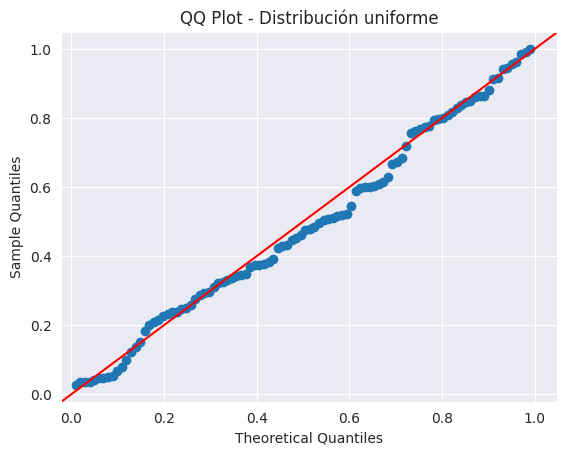

In [23]:
qq_plot(muestra1)

#### Muestra 2 (n = 1000)

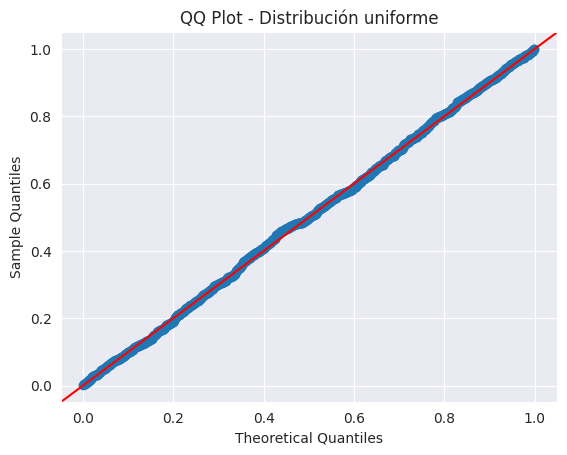

In [24]:
qq_plot(muestra2)

#### Muestra 3 (n = 100000)

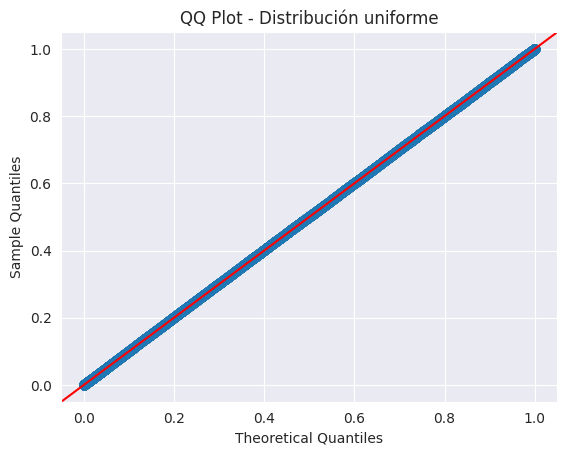

In [25]:
qq_plot(muestra3)

#### Resultados

Nuevamente, vemos que con la muestra pequeña, los cuantiles de la muestra distan bastante de los cuantiles teóricos, de modo que podriamos rechazar nuestra hipótesis nula (la muestra sigue una distribución uniforme).

Sin embargo, al pasar a una muestra de tamaño 1000 ya se notan grandes cambios favorables dado a que ambos cuantiles son relativamente similares. Por último, con la muestra de tamaño 100000, vemos una coincidencia mucho más precisa entre los dos cuantiles formándose una diagonal practicamente recta. En base a estos gráficos, podríamos decir que para las muestras de n=1000 y n=100000 no hay evidencia suficiente para rechazar nuestra hipótesis nula.

### Test Expectral

Usaremos un scatter plot para poder ver gráficamente si hay algun patron entre numeros consecutivos generados. En el caso ideal se debería observar puntos dispersos por todo el grafico sin ningun patron.

In [26]:
# Grafica el scatter Plot
def scatter_plot(muestra):
  length = len(muestra)
  n_obs = observaciones[:length - 1]
  n_plus_1_obs = observaciones[1:length]

  sns_scat=sns.scatterplot(x=n_obs, y=n_plus_1_obs).set(xlabel='n obseraciones', ylabel='n+1 observaciones')    
  plt.title('Test espectral - Distribución uniforme')
  plt.show()

#### Muestra 1 (n = 100)

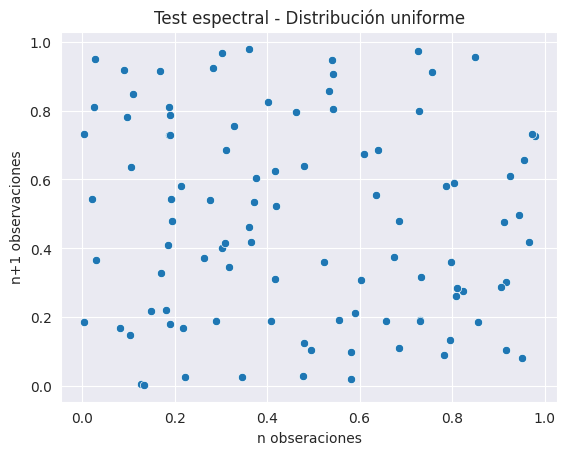

In [27]:
scatter_plot(muestra1)

#### Muestra 2 (n = 1000)

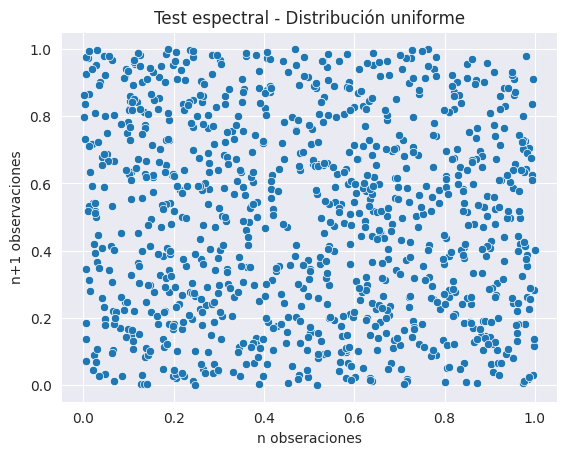

In [28]:
scatter_plot(muestra2)

#### Muestra 3 (n = 100000)

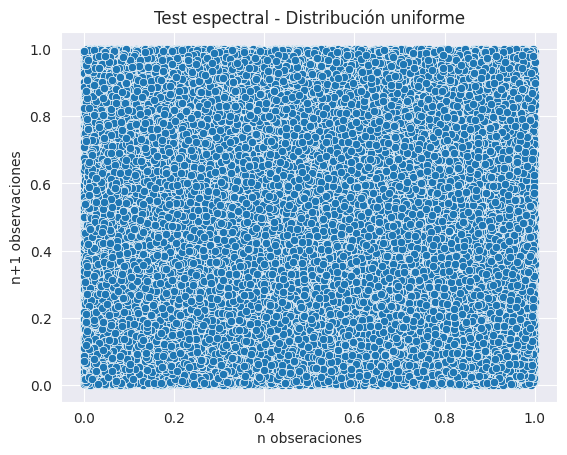

In [29]:
scatter_plot(muestra3)

#### Resultados

Vemos que en ninguno de los graficos mostrados se puede observar algun patron visible, por lo cual podemos concluir que pasa este test.

## Ejercicio 3

In [30]:
class GeneradorVariableNormal:
    def __init__(self, media, desvio, rnd_gen):
        self.media = media
        self.desvio = desvio
        self.gen = rnd_gen
        self.c = self.fx(1)/self.fy(1)

    def fx(self, x):
        # Se usó N(0, 2) y luego se la desplazó en 10(de su media original)
        return stats.norm(0, 2).pdf(x)

    def fy(self, t):
        return stats.expon.pdf(t, 0, 4)
    def muestras_en_iteraciones(self, iteraciones):
        muestras = []
        candidatos = 0
        for _ in tqdm(range(0, iteraciones)):
            # Generador Ej. 1
            rnd_u = self.gen.rnd_cero_uno()
            # fy
            rnd_x = np.random.exponential(4)
            if rnd_u < (self.fx(rnd_x)/(self.c*self.fy(rnd_x))):
                rnd_u2 = self.gen.rnd_cero_uno()
                # Con probabilida 0.5 dejamos de lado positivo o negativo
                if rnd_u2 < 0.5:
                    # Desplazamos de su media
                    muestras.append(self.media-rnd_x)
                else:
                    muestras.append(rnd_x+self.media)
                candidatos += 1
        print("Factor de rendimiento:", candidatos/iteraciones)
        return muestras

# Grafica la distribución
def grafica_histograma_normal(muestra):
    plt.hist(muestra, align="left", bins=100)
    plt.show()

def imprimir_p_valor(x):
    p_valor = stats.norm.cdf(x, 10, 2)
    print(f"P-valor teórico: {p_valor*2}")

# Grafica el QQ Plot
def qq_plot_norm(muestra):
    sm.qqplot(np.array(muestra), line='45', dist=distributions.norm(loc=10, scale=2))
    plt.title('QQ Plot - NormalGenerada(10, 2) vs Normal(10, 2)')
    plt.show()

# Test de Anderson-Darling
def test_anderson(muestra):
    resultado = stats.anderson(muestra)
    print("Estadistico: %.3f" % resultado.statistic)
    print("HO: Los datos siguen una distribución Normal")
    for i in tqdm(range(len(resultado.critical_values))):
        alfa, cuantil = resultado.significance_level[i]/100, resultado.critical_values[i]
        if resultado.statistic < resultado.critical_values[i]:
            print("Nivel de significación: %.3f,  %.3f < %.3f(Valor crítico) No hay evidencia suficiente para rechazar H0" % (alfa, resultado.statistic, cuantil))
        else:
            print("Nivel de significación: %.3f,  %.3f > %.3f(Valor crítico) Rechazamos H0" % (alfa, resultado.statistic, cuantil))


Para crear el generador, usamos como función de densidad cantidata la exponcial de parametro 1/4. Graficamos las distribuciones Normal(0, 2) y la Exp(1/4) para confirmar si nuestra densidad candidata acotaba bien a la distribución Normal(0, 2). Para llevar a la distribución solicitada usamos la propiedad de las distribuciones normales:
Sea X una distribución Normal, X  N(a, b), entonces X + q ~ N(q+a, 2)

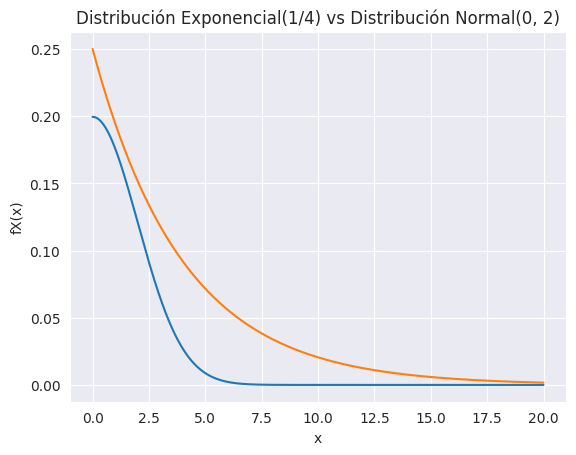

In [57]:
x_axis = np.arange(0, 20, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,0,2))
y = stats.expon.pdf(x_axis, 0, 4)
plt.plot(x_axis, y)
plt.title("Distribución Exponencial(1/4) vs Distribución Normal(0, 2)")
plt.xlabel("x")
plt.ylabel("fX(x)")
plt.show()

In [56]:
generador_normal = GeneradorVariableNormal(10, 2, generador)
muestra4 = generador_normal.muestras_en_iteraciones(2000)
muestra5 = generador_normal.muestras_en_iteraciones(20000)
muestra6 = generador_normal.muestras_en_iteraciones(100000)


100%|██████████| 2000/2000 [00:02<00:00, 928.28it/s] 


Factor de rendimiento: 0.5535


100%|██████████| 20000/20000 [00:19<00:00, 1006.11it/s]


Factor de rendimiento: 0.55075


100%|██████████| 100000/100000 [01:55<00:00, 869.26it/s]

Factor de rendimiento: 0.55334


### Distribución generada


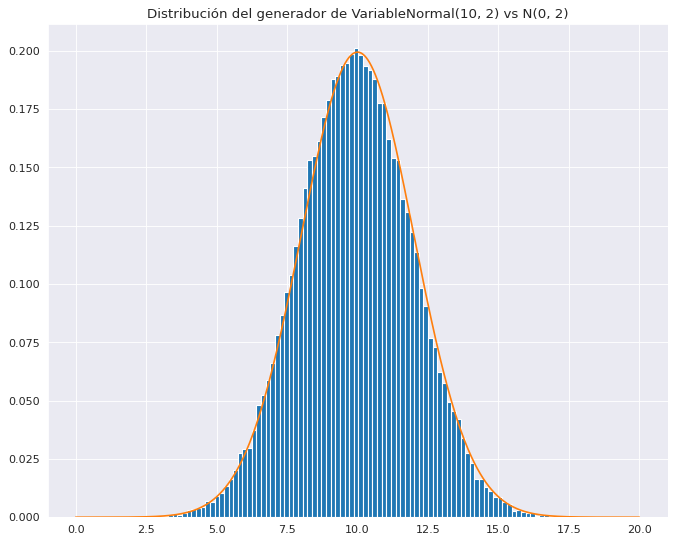

In [65]:
from matplotlib.pyplot import figure

figure(figsize=(10, 8), dpi=80)
plt.hist(muestra6, align="left", bins=100, density=True)
plt.title("Distribución del generador de VariableNormal(10, 2) vs N(0, 2)")
x_axis = np.arange(0, 20, 0.001)
plt.plot(x_axis, norm.pdf(x_axis,10,2))
plt.show()

### QQ Plot

Se realizan 3 tests QQ plot para los tres tamaños de muestra generados. Se puede apreciar es que hay una correlación entre la generada y normal de media 10 y desvío 2, aunque en los extremos hay una ligera diferencia en los extremos, sobre todo en el primer gráfico. Luego, a medida que se aumenta la cantidad de muestras el resultado es mejor(acumulan la misma probabilidad).

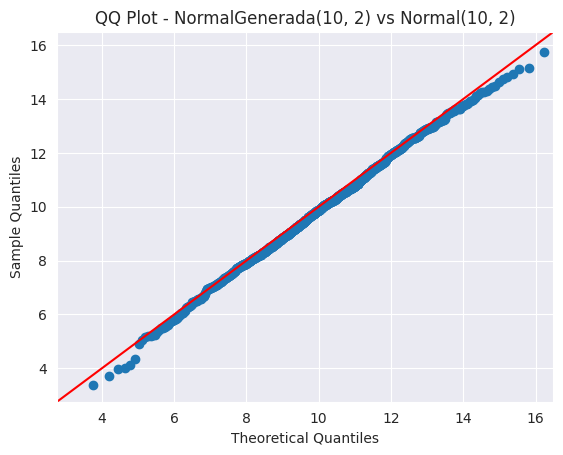

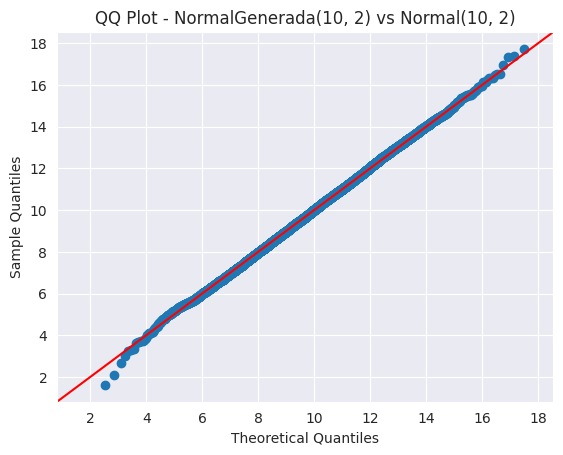

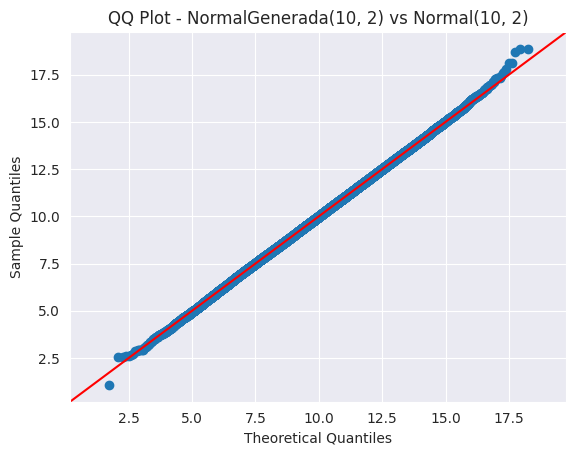

In [34]:
# Para las tres muestras
qq_plot_norm(muestra4)
qq_plot_norm(muestra5)
qq_plot_norm(muestra6)

### Test de Anderson-Darling


In [35]:
print("Cantidad de iteraciones: 2000")
test_anderson(muestra4)
imprimir_p_valor(0.199)

Cantidad de iteraciones: 2000
Estadistico: 0.284
HO: Los datos siguen una distribución Normal


100%|██████████| 5/5 [00:00<00:00, 14198.73it/s]

Nivel de significación: 0.150,  0.284 < 0.574(Valor crítico) No hay evidencia suficiente para rechazar H0
Nivel de significación: 0.100,  0.284 < 0.654(Valor crítico) No hay evidencia suficiente para rechazar H0
Nivel de significación: 0.050,  0.284 < 0.784(Valor crítico) No hay evidencia suficiente para rechazar H0
Nivel de significación: 0.025,  0.284 < 0.915(Valor crítico) No hay evidencia suficiente para rechazar H0
Nivel de significación: 0.010,  0.284 < 1.088(Valor crítico) No hay evidencia suficiente para rechazar H0
P-valor teórico: 9.55930577824612e-07


In [36]:
print("Cantidad de iteraciones: 20000")
test_anderson(muestra5)

Cantidad de iteraciones: 20000
Estadistico: 0.399
HO: Los datos siguen una distribución Normal


100%|██████████| 5/5 [00:00<00:00, 15863.48it/s]

Nivel de significación: 0.150,  0.399 < 0.576(Valor crítico) No hay evidencia suficiente para rechazar H0
Nivel de significación: 0.100,  0.399 < 0.656(Valor crítico) No hay evidencia suficiente para rechazar H0
Nivel de significación: 0.050,  0.399 < 0.787(Valor crítico) No hay evidencia suficiente para rechazar H0
Nivel de significación: 0.025,  0.399 < 0.918(Valor crítico) No hay evidencia suficiente para rechazar H0
Nivel de significación: 0.010,  0.399 < 1.092(Valor crítico) No hay evidencia suficiente para rechazar H0


In [37]:
print("Cantidad de iteraciones: 100000")
test_anderson(muestra6)

Cantidad de iteraciones: 100000
Estadistico: 0.302
HO: Los datos siguen una distribución Normal


100%|██████████| 5/5 [00:00<00:00, 14862.88it/s]

Nivel de significación: 0.150,  0.302 < 0.576(Valor crítico) No hay evidencia suficiente para rechazar H0
Nivel de significación: 0.100,  0.302 < 0.656(Valor crítico) No hay evidencia suficiente para rechazar H0
Nivel de significación: 0.050,  0.302 < 0.787(Valor crítico) No hay evidencia suficiente para rechazar H0
Nivel de significación: 0.025,  0.302 < 0.918(Valor crítico) No hay evidencia suficiente para rechazar H0
Nivel de significación: 0.010,  0.302 < 1.092(Valor crítico) No hay evidencia suficiente para rechazar H0


Los resultados del Test de Anderson muestran que los estadísticos calculados son relativamente más chicos que los valores críticos(por lo tanto su p-valor). También observamos que no se rechaza H0 incluso para niveles de signifación del 1%.

Concluimos nuestro generador es relativamente bueno para generar variables aleatorias con distribución de media 10 y desvío estándar 2 aunque no es del todo eficiente.

## Ejercicio 4

La llegada de vehículos a un estacionamiento sigue un proceso de Poisson de tasa λ vehículos/hora. En el trabajo práctico se incluye un archivo con números pseudoaleatorios que representan los tiempos entre arribos de dichos vehículos.

* Realice una estimación de la tasa de arribos y proponga un test para evaluar si los números pseudoaleatorios provistos siguen la distribución esperada.

* Utilizando el GCL implementado en el Ejercicio 1 simular la llegada de vehículos durante un mes. Graficar la cantidad de arribos en función del tiempo.

* Generar 1000 realizaciones del proceso de Poisson para estimar las siguientes probabilidades:

    1. Probabilidad que el primer vehículo arribe antes de los 10 minutos.
    2. Probabilidad que el undécimo vehículo arribe después de los 60 minutos.
    3. Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.


### Cargando datos.

In [38]:
def llenar_lista_arribos():
    with open("data/tiempos_entre_arribos.txt") as archivo:
        lista_arribos = []
        for linea in archivo:
            lista_arribos.append(float(linea))
        return lista_arribos

lista_arribos = llenar_lista_arribos()
len(lista_arribos)

10000

### a) Estimacion de la Tasa de arribos

[comment]: <![Captura%20de%20pantalla%20de%202022-09-21%2019-29-01.png](attachment:Captura%20de%20pantalla%20de%202022-09-21%2019-29-01.png)> 

In [39]:
def promedio(lista):
    contador = 0
    for int in lista:
        contador += int
    return contador/10000


tasa = 1/promedio(lista_arribos)


Me genero una lista de variables con la distribucion exponencial para luego comparar con la dada.

In [40]:
var_exp_generadas =expon.rvs(scale = 1/tasa ,size=10000)


Usamos el Test de Kolmogorov Smirnov

Actualizo la funcion ya generada anteriormente.

In [41]:
# Grafica las funciones ECFD y CFD
def plot_ecfd_vs_cfd_EJ4(muestra_observada, muestra_esperada):
    plt.figure()
    sns.ecdfplot(data=muestra_esperada, label='ECDF')
    sns.ecdfplot(data=muestra_observada, label='CDF')
#     uniform_data = np.linspace(0,1,len(muestra))
#     plt.plot(np.sort(uniform_data), np.linspace(0, 1, len(uniform_data), endpoint=False), color='r', label='CDF')

    plt.legend(title="Funciones")
    plt.ylabel("F(x)")
    plt.xlabel("x")
    plt.title('ECDF vs CDF')
    plt.show()
    

# Test Kolmogorov-Smirnov
def test_kolmogorov_smirnov_EJ4(muestra):
    estadistico_ks, pvalor_ks=kstest(lista_arribos, var_exp_generadas)
    print("KS = %f, pValor = %f" % (estadistico_ks, pvalor_ks))

    if pvalor_ks < 0.05:
        print("Se rechaza la hipótesis nula")
    else:
        print("Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).")

In [42]:
test_kolmogorov_smirnov_EJ4(lista_arribos)

KS = 0.012000, pValor = 0.467577
Se acepta la hipótesis nula (no hay evidencia suficiente para rechazarla).


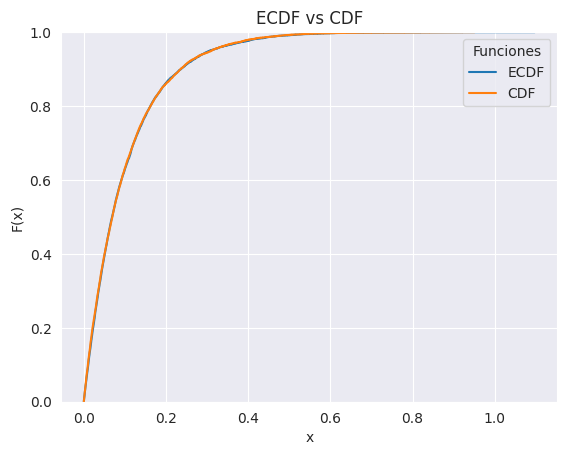

In [43]:
plot_ecfd_vs_cfd_EJ4(lista_arribos,var_exp_generadas)

### b) Simulación llegada de Vehículos en 1 mes

A continuación modelamos un proceso de Poisson, con el cual podemos simular la cantidad de arribos durante una determinada cantidad de tiempo. El tiempo transcurrido entre dos arribos sigue una distribución exponencial, y la cantidad de arribos sigue una distribución de Poisson.

In [44]:
class ProcesoPoisson:
    def __init__(self, tasa, duracion_en_horas):
        self.tasa = tasa
        self.duracion = duracion_en_horas
        self.tiempos = []
        self.arribos = []
        
    def simular_arribos(self):
        t = 0
        k = 0
        while t < self.duracion:
            u = generador.rnd_cero_uno()
            # Inversa de la exponencial. Arribo
            y  = -np.log(1 - u)/self.tasa
            # Tiempo acumulado
            t = t + y
            k = k + 1
            if(t <= self.duracion):
                self.tiempos.append(t)
                self.arribos.append(k)

def grafico_arribos_vs_tiempo(tiempos, arribos):
    plt.plot(tiempos, arribos)
    plt.title("Arribo de Vehiculos(tasa 9.88 Vehículos/hora)")
    plt.ylabel("Arribos")
    plt.xlabel("Tiempo(horas)")
    plt.show()

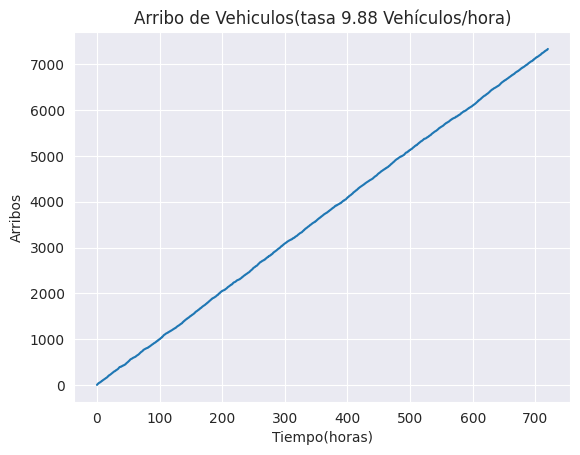

In [45]:
proceso_poisson = ProcesoPoisson(tasa, 24*30)
proceso_poisson.simular_arribos()
grafico_arribos_vs_tiempo(proceso_poisson.tiempos, proceso_poisson.arribos)

En el gráfico anterior, dada la tasa, no se puede apreciar correctamente los arribos entre los tiempos. Como alternativas teníamos: Cambiar las unidades a días o mostrar el mismo gráfico pero acotado en horas a 5 horas por ejemplo. Optamos por la segunda opción cuyo gráfico es el siguiente:

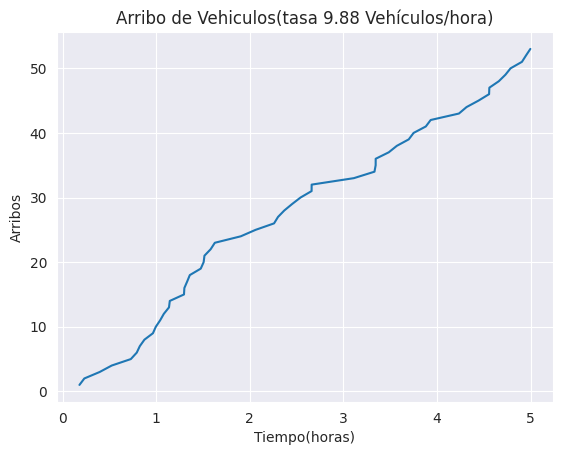

In [46]:
proceso_poisson = ProcesoPoisson(tasa, 5)
proceso_poisson.simular_arribos()
grafico_arribos_vs_tiempo(proceso_poisson.tiempos, proceso_poisson.arribos)

### c) Estimación de probabilidades

#### 1. Probabilidad que el primer vehículo arribe antes de los 10 minutos.

Primero pasamos los minutos a horas: 10 minutos = 0.6 horas.

Luego, vemos que podemos encarar este problema desde dos puntos de vista:

* Primera forma:

Sea N la variable aleatoria que representa la cantidad de arribos durante los primeros 10 minutos.
Entonces, N ~ Poi(0.6𝜆)

Por lo tanto, hay que calcular:
$$
P(N >= 1)
$$

* Segunda forma:

Sea T la variable aleatoria que representa el tiempo transcurrido en horas hasta el primer arribo.
Entonces, T ~ Exp(𝜆)

Por lo tanto, hay que calcular:
$$
P(T < 0.6)
$$

Donde 𝜆 es la tasa estimada en el punto a)

A continuación definimos la función que usaremos para simular n procesos de Poisson durante una determinada cantidad de horas y obtener la cantidad total de arribos por cada proceso.

In [47]:
def simular_arribos_procesos_poisson(cant_procesos, duracion_en_horas, tasa):
    arribos_por_proceso = []
    for i in range(0,cant_procesos):
        proceso = ProcesoPoisson(tasa, duracion_en_horas)
        proceso.simular_arribos()
        if not proceso.arribos:
            arribos_por_proceso.append(0)
        else:
            arribos_por_proceso.append(proceso.arribos[-1])
            
    return arribos_por_proceso

# Generar variables con distribución exponencial
def generar_exponenciales(cantidad, tasa):
    exp = []
    for i in range(0,cantidad):
        u = generador.rnd_cero_uno()
        exp.append(-np.log(1 - u)/tasa)
    return exp

Simulamos 1000 procesos de Poisson durante 0.6 horas (10 minutos), contamos los arribos y luego estimamos la probabilidad haciendo:
    $$
    \frac{casos\ favorables}{casos\ totales}
    $$

In [48]:
arribos_por_proceso = simular_arribos_procesos_poisson(1000, 0.6, tasa)

casos_favorables = 0
for arribos in arribos_por_proceso:
    if arribos >= 1:
        casos_favorables+=1

proba = casos_favorables/len(arribos_por_proceso)
proba

0.997

Ahora, si estimamos la probabilidad utilizando variables con distribución exponencial, deberiamos obtener una probabilidad similar, asi que probamos.

In [49]:
# Generamos las variables exponenciales
exp = generar_exponenciales(1000, tasa)

# Contamos casos favorables
casos_favorables = 0
for e in exp:
    if e < 0.6:
        casos_favorables+=1

proba = casos_favorables/len(exp)
proba

0.996

Efectivamente, la probabilidad dio similar

#### 2. Probabilidad que el undécimo vehículo arribe después de los 60 minutos.

Primero pasamos los minutos a horas: 60 minutos = 1 hora.

* Primera forma:

Sea N la variable aleatoria que representa la cantidad de arribos durante los 60 minutos.
Entonces, N ~ Poi(1𝜆)

Por lo tanto, hay que calcular:
$$
P(N < 11)
$$

* Segunda forma:

Sea T la variable aleatoria que representa el tiempo transcurrido en horas hasta el undécimo arribo.
Entonces, T ~ Γ(11,𝜆)

Por lo tanto, hay que calcular:
$$
P(T > 1)
$$

Donde 𝜆 es la tasa estimada en el punto a)

Simulamos 1000 procesos de Poisson durante 1 hora, contamos los arribos y luego estimamos la probabilidad haciendo:
    $$
    \frac{casos\ favorables}{casos\ totales}
    $$

In [50]:
arribos_por_proceso = simular_arribos_procesos_poisson(1000, 1, tasa)

casos_favorables = 0
for arribos in arribos_por_proceso:
    if arribos < 11:
        casos_favorables+=1

proba = casos_favorables/len(arribos_por_proceso)
proba

0.578

Ahora, si estimamos la probabilidad utilizando variables con distribución gamma (suma de exponenciales), deberiamos obtener una probabilidad similar, asi que probamos.

In [51]:
def generar_gamma(cantidad,k, tasa):
    gamma = []
    for i in range(0,cantidad):
        gamma.append(sum(generar_exponenciales(k,tasa)))
    return gamma

# Generamos las variables gamma
gamma = generar_gamma(1000, 11, tasa)

# Contamos casos favorables
casos_favorables = 0
for g in gamma:
    if g > 1:
        casos_favorables+=1

proba = casos_favorables/len(gamma)
proba

0.599

De nuevo, la probabilidad da similar estimandola de ambas formas

#### 3. Probabilidad que arriben al menos 750 vehículos antes de las 72 horas.

* Primera forma:

Sea N la variable aleatoria que representa la cantidad de arribos durante las 72 horas.
Entonces, N ~ Poi(72𝜆)

Por lo tanto, hay que calcular:
$$
P(N >= 750)
$$

* Segunda forma:

Sea T la variable aleatoria que representa el tiempo transcurrido en horas hasta el arribo número 750.
Entonces, T ~ Γ(750,𝜆)

Por lo tanto, hay que calcular:
$$
P(T < 72)
$$

Donde 𝜆 es la tasa estimada en el punto a)

Simulamos 1000 procesos de Poisson durante 72 horas, contamos los arribos y luego estimamos la probabilidad haciendo:
    $$
    \frac{casos\ favorables}{casos\ totales}
    $$

In [52]:
arribos_por_proceso = simular_arribos_procesos_poisson(1000, 72, tasa)

casos_favorables = 0
for arribos in arribos_por_proceso:
    if arribos >= 750:
        casos_favorables+=1

proba = casos_favorables/len(arribos_por_proceso)
proba

0.085

Ahora, si estimamos la probabilidad utilizando variables con distribución gamma (suma de exponencial), deberiamos obtener una probabilidad similar, asi que probamos.

In [53]:
# Generamos las variables gamma
gamma = generar_gamma(1000, 750, tasa)

# Contamos casos favorables
casos_favorables = 0
for g in gamma:
    if g < 72:
        casos_favorables+=1

proba = casos_favorables/len(gamma)
proba

0.103

De nuevo, la probabilidad da similar estimandola de ambas formas


## Ejercicio 5


A partir del generador de número al azar implementado en el ejercicio 1, y del dataset provisto, obtenido del sitio de datos abiertos del Gobierno de la Ciudad de Buenos Aires (data.buenosaires.gob.ar), el cual contiene información geográfica de barrios de la Ciudad de Buenos Aires, se pide:

https://drive.google.com/file/d/1OrWKtWta5cZSzPuVd9L7w_mrG1ax2a71/view

link de los datos

In [54]:
def create_data_frame():
    with open('caba_barrios.json') as f:  
        data = json.load(f)

        df_barrios = pd.DataFrame()
        df_barrios['barrio'] = None
        df_barrios['latitud'] = None
        df_barrios['longitud'] = None

        for barrio  in data["features"]:
            for coordenada in barrio["geometry"]["coordinates"][0][0]:   
                nueva_fila = {"barrio" : barrio["properties"]["BARRIO"], "latitud": coordenada[0],"longitud": coordenada[1]}
                df_barrios = df_barrios.append(nueva_fila, ignore_index=True)

        return df_barrios

In [55]:
df_barrios = create_data_frame()
print(df_barrios)

FileNotFoundError: [Errno 2] No such file or directory: 'caba_barrios.json'

In [ ]:
for barrio in df_barrios['barrio'].unique():
  df_barrio = df_barrios[df_barrios['barrio'] == barrio]
  plt.plot(df_barrio['latitud'],df_barrio['longitud'])
  
plt.show()

In [ ]:
df_barrio = df_barrios[df_barrios['barrio'] == 'CHACARITA']
plt.plot(df_barrio['latitud'],df_barrio['longitud'])
plt.show()

In [ ]:
max_latitud = df_barrio['latitud'].max()
min_latitud = df_barrio['latitud'].min()
max_longitud = df_barrio['longitud'].max()
min_longitud = df_barrio['longitud'].min()
print(max_latitud, min_latitud, max_longitud, min_longitud)

In [ ]:
x = generador.muestra_entre(min_latitud, max_latitud, 1)[0]
y = generador.muestra_entre(min_longitud, max_longitud, 1)[0]
print(x,y)

In [ ]:
df_barrio.loc[:,['latitud', 'longitud']].iloc[0]

In [ ]:
l = df_barrio.loc[:,['latitud', 'longitud']]['latitud']
all(l[i] <= l[i+1] for i in range(len(l) - 1))

In [ ]:
for i in range(0, len(df_barrio) - 1):
    df_barrio['latitud', 'longitud'][i]

In [ ]:
def pretenece_a_caba(x,y):                         
    r = 0.5         #radio
    xi = 0.5        # x del centro de círculo
    yi = 0.5        # y del centro de círculo
    return ((x-xi)**2 + (y-yi)**2) < r**2

def generar_puntos_en_caba(n):
  z = generar_pares_de_puntos(n)            
  count = 0
  for i in z:
    x = i[0]
    y = i[1]
    count += pretenece_al_ciculo(x, y)
  texto=' De {} puntos, {} puntos están en el círculo, teniendo un factor de rendimiento de {} , y calculando un pi aproximado de {}.'.format(n,count, count/n, 4*count/n)
  print(texto)